In [1]:
from collections import OrderedDict
from copy import copy
import crossed_cavity_network
import qdyn_model
from notebook_plots import display_hamiltonian
from sympy import Symbol
import QDYN
from QDYN.pulse import blackman
from QDYN.shutil import mkdir

In [2]:
%load_ext autoreload
%autoreload 2

## Circuit

In [3]:
circuit = crossed_cavity_network.network_circuit(n_nodes=2, topology='FB')

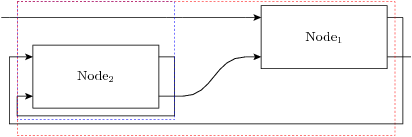

In [4]:
circuit.show()

In [5]:
slh = crossed_cavity_network.network_slh(n_cavity=2, n_nodes=2, topology='FB')

In [6]:
slh.S

[[1]]

In [7]:
slh.L

[[√2⋅√κ * â^(h₁) + √2⋅√κ * b̂^(v₁) + √2⋅√κ * â^(h₂) + √2⋅√κ * b̂^(v₂)]]

In [8]:
display_hamiltonian(slh.H)

<IPython.core.display.Latex object>

## Numerical Values

In [9]:
controls = sorted([sym for sym in slh.H.all_symbols() if sym.name.startswith('Omega')], key=str)

In [10]:
from algebra import generate_num_vals_code
generate_num_vals_code(slh.all_symbols())

num_vals = {
    Symbol('g_2', positive=True): 0.0,
    Symbol('Delta_2', real=True): 0.0,
    Symbol('g_1', positive=True): 0.0,
    Symbol('kappa', positive=True): 0.0,
    Symbol('Delta_1', real=True): 0.0,
    Symbol('Omega_2'): 0.0,
    Symbol('Omega_1'): 0.0,
}


In [11]:
Delta =  5000.0  # MHz
g     =    50.0  # MHz
kappa =     0.5  # MHz
E0    =    70.0  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001
num_vals = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('g_2', positive=True):   g,
    Symbol('g_1', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
}

## Time Grid and Guess Pulse

In [12]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [13]:
p = QDYN.pulse.Pulse(
    tgrid, amplitude=(E0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [14]:
controls = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
])

## OCT for forward transfer (rho)

In [15]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=False, oct_target='excitation_transfer_fw',
    lambda_a=1e-4)

In [16]:
model.write_to_runfolder("./CROSSED/fw_oct_rho001/")

##  OCT for $\sqrt{SWAP}$ (rho)

In [17]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=False, oct_target='sqrt_SWAP',
    lambda_a=1e-4)

In [18]:
model.write_to_runfolder("./CROSSED/sqrtSWAP_oct_rho001/")
QDYN.gate2q.sqrt_SWAP.write("./CROSSED/sqrtSWAP_oct_rho001/target_gate.dat")

## Example optimization commands

*   density matrix optimization
        OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --rho
--debug --J_T=J_T_re .

*   trajectory optimization (model with `mcwf=True`)

        OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt
--n-trajs=20 --J_T=J_T_sm .